<a href="https://colab.research.google.com/github/Benjamin025/Benjamin025/blob/main/Eritrea_Watershed_Delineation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CATCHMENT/ WATERSHED DELIANATION IN GOOGLE COLAB.
  # ENC222-0198/2021
  # KARANJA BENJAMIN NDUNG'U
  # EGS 2403
  # REMOTE SENSING APPLICATIONS

#  1.Installing required packages

In [ ]:
# Installing "earthengine api" for connecting to google earth engine. installing and initializing the api
# The api allows the utiliation of earth engine datasets in a notebook environment.
# "geemap" is used to create an interactive map widget
# "rasterio" is used for raster calculations in python
!pip install earthengine-api geemap rasterio

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 21.0 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
#A fast, open-source digital elevation model processing library.
pip install pysheds

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysheds: filename=pysheds-0.4-py3-none-any.whl size=90687 sha256=5ed8d042f5070a2967a82cf6adff653e00a031f447b494fd148a523ab9bdc476
  Stored in directory: /root/.cache/pip/wheels/8f/2b/0d/988f11a32332312c4d5dfe1720f891789e5b01853f6a842be6
Successfully built pysheds


## Loading necessary packages

In [ ]:
# ee for earth eengine usage
import ee
# for creating interactive widgets
import geemap
# for raster calculations
import rasterio
# for files upload
from google.colab import files

## Authenticate and Initialize Google earth engine

In [ ]:
# authentication of gee
ee.Authenticate()

# triggering the initialization process
ee.Initialize(project="ee-my-tana")

## Adding an interactive map

In [ ]:
Map = geemap.Map()

## Uploading Digital Elevation Models(DEM's) for delineation process

### Due to challenges in uploading the entire Dem covering the whole country a section of the Dem tile was uploaded.

In [ ]:
uploaded = files.upload()

Saving N14E040.tif to N14E040.tif


### Importing "grid" class from pysheds
### "grid" is used for hydrological modeling and terrain analysis.

In [ ]:
# "grid" import from pysheds
 from pysheds.grid import Grid

#  Creating a grid object grid class from pysheds based on the uploaded DEM data.
grid = Grid.from_raster('/content/N14E040.tif')

# Read the DEM data from the raster files
dem = grid.read_raster('/content/N14E040.tif')

### Installing Essential libraries for data Visualization and analysis

In [ ]:
# "numpy" for numerical computations
# Provides support for large, multi-dimensional arrays and matrices for mathematical functions
import numpy as np

# "matplotlib.pyplot" for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt

# "colours" provides utilities for handling colors and color maps
from matplotlib import colors

#"seaborn" is a statistical data visualization library
# based on "matplotlib"provides a high-level interface for drawing attractive and informative statistical graphics.
import seaborn as sns

## Plot the DEM data uploaded

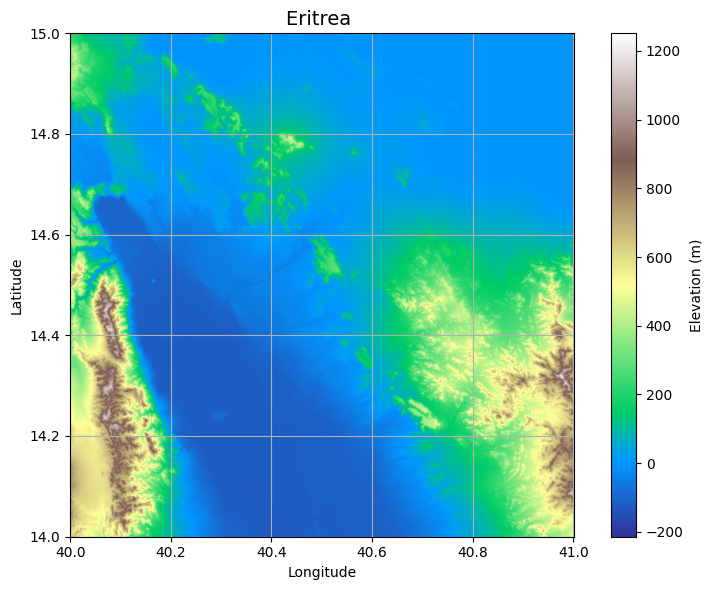

In [ ]:

#initialize a figure and axes for plotting, setting the figure size to 8x6 inches.
fig, ax = plt.subplots(figsize=(8,6))

# Set the background color of the figure to transparent.
fig.patch.set_alpha(0)

#Displaythe DEM (a 2D array of elevation data) as an image
    # "extent=grid.extent" set the bounds for the image based on the extent of the grid.
    #"cmap=terrain"use a terrain-like color scheme for the elevation map.
    #zorder=1 ensure that the layer is drawn above the grid (which has zorder=0).
plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)

#Adds a color bar to indicate elevation values, with units in meters.
plt.colorbar(label='Elevation (m)')

#Adds a grid to the plot, set to appear beneath the DEM (zorder=0).
plt.grid(zorder=0)

#add title
plt.title('Eritrea ', size=14)

# add x and y labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#Ensures that the layout is adjusted to prevent overlaps between elements.
plt.tight_layout()

### condition the Digital Elevation Model (DEM) to ensure accurate hydrological analysis by filling pits, depressions, and resolving flat areas

In [ ]:
# CONDITION DEM
# Fill pits in DEM -- ensure continuous flow for hydrological modeling.
# "Pits'are local depressions in the DEM that do not drain anywhere
pit_filled_dem = grid.fill_pits(dem)

# FILL depressions in the filled DEM
# Depressions are larger areas of low elevation that may prevent water from flowing naturally.
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
#Flat areas can cause problems in determining flow direction, as water may not naturally flow downhill in these regions.
#This function adjusts flat areas to ensure that a flow direction can be determined.
inflated_dem = grid.resolve_flats(flooded_dem)

#### Determining the D8 flow directions from the conditioned DEM.
####     Used in hydrological modeling to route water from each cell to one of its 8 neighboring cells based on the steepest descent.
#### dirmap = (64, 128, 1, 2, 4, 8, 16, 32):

### This array represents the D8 directional encoding for flow directions. The 8 directions represent the flow toward one of the eight neighboring cells, with values indicating each direction (north, northeast, east, southeast, south, southwest, west, northwest).
###For instance:
  #### 1 = East
  #### 2 = Southeast
  #### 4 = South
  #### 8 = Southwest
  #### 16 = West
  #### 32 = Northwest
  #### 64 = North
  #### 128 = Northeast

In [ ]:
# Determine D8 flow directions from DEM

# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
#This function computes the flow direction for each cell in the DEM (inflated_dem).
#The D8 algorithm assigns each cell a value that represents the direction of steepest descent using the dirmap array.
#fdir: The result is a flow direction grid where each cell holds a value representing the direction water will flow to from that cell.

fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

## Plotting the Flow Directions

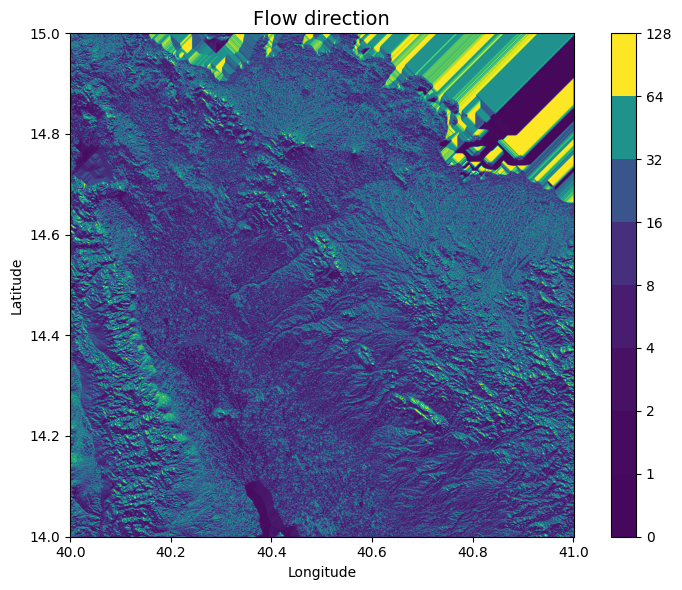

In [ ]:
# Initialize a figure and axes for plotting, setting the figure size to 8x6 inches.
fig = plt.figure(figsize=(8,6))
# Set background color to transparent
fig.patch.set_alpha(0)
# Displaythe DEM( 2D array)
plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
# Ensures that the color bar aligns with the unique values in the "dirmap", which represent the 8 D8 directions.
boundaries = ([0] + sorted(list(dirmap)))
# Adds a color bar using the boundaries parameter to ensure the color bar represents the different D8 direction values.
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
# add x, y labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction', size=14)
# adds a grid beneath the flow directions
plt.grid(zorder=-1)
# Ensures that the layout is adjusted to prevent overlaps between elements.
plt.tight_layout()

## Calculate Flow Accumulation


In [ ]:
# Calculate flow accumulation
# "grid.accumulation() function. Computes how many upstream cells contribute flow to each cell,
# based on the D8 flow direction grid (fdir).
# The result will be a flow accumulation grid where higher values indicate more upstream cells contributing to flow at that point.
acc = grid.accumulation(fdir, dirmap=dirmap)

### Visualizing the flow accumulation

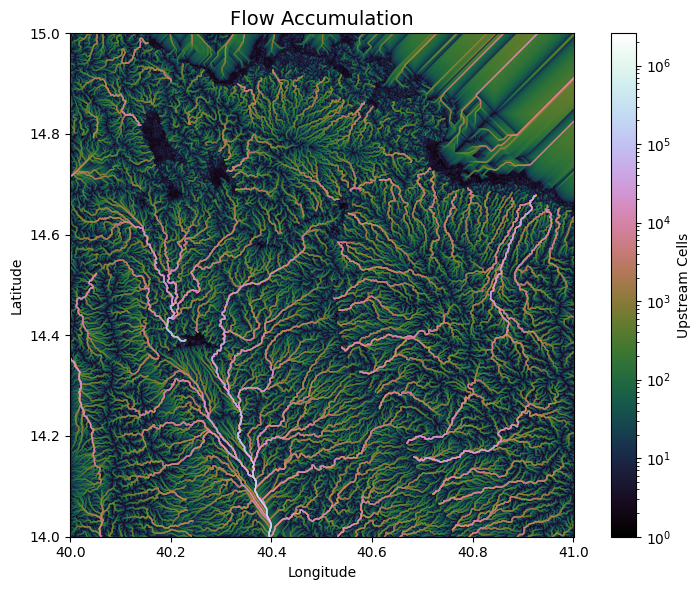

In [ ]:
# Initializing a 8*6 plot
fig, ax = plt.subplots(figsize=(8,6))
# Set background colorr to be transparent
fig.patch.set_alpha(0)
# Display 2D array for the image
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
# Align the color bar
plt.colorbar(im, ax=ax, label='Upstream Cells')
# add x, y labels and tiltle
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# adjust the layout to prevent overlaps
plt.tight_layout()

## Delineate Catchment
   ### Using the flow direction and flow accumulation grids

In [ ]:
# Delineate a catchment

# first: Define the outpour point
# The initial pour point for the catchment
x, y = -97.294, 32.737

# Second: Snap pour point to high accumulation cell
# The snap_to_mask function adjusts the pour point to the nearest cell with significant flow accumulation (greater than 1000 in this case).
# This ensures the pour point is located on a river or drainage path.
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Third: Delineate the catchment
# This line uses the snapped pour point coordinates and flow direction to delineate the catchment area.
#The "catchment" function traces upstream from the pour point using the flow direction grid.
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                       xytype='coordinate')

# Fourth: Crop and plot the catchment
# The code clips the DEM and the flow direction grid to the extent of the delineated catchment.
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

## Plot the Catchment

Text(0.5, 1.0, 'Delineated Catchment')

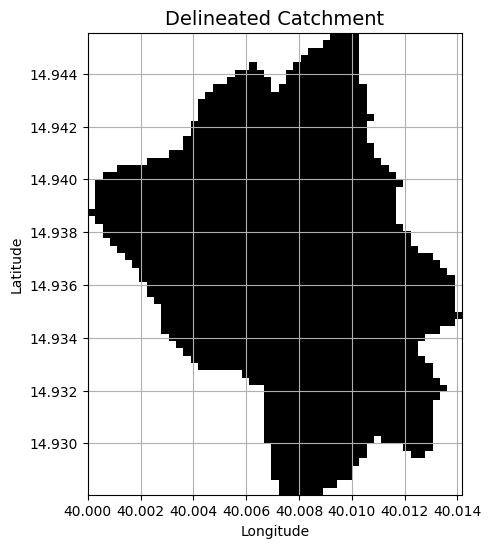

In [ ]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))

# Set the background color as transparent
fig.patch.set_alpha(0)

# Display  a 2D array
plt.grid('on', zorder=0)

# Plot the clipped DEM
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
# Label x,y axis and add
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

### Extract River Network.
   ### extracts the river network using the flow direction (fdir) and flow accumulation (acc) grids, with a threshold (acc > 50) to determine where streams begin.

In [ ]:
# Extract river network

# "grid.extract_river_network()"":identifies the river branches based on the D8 flow direction grid (fdir) and the flow accumulation grid (acc).
# The threshold acc > 50 ensures that only cells with significant upstream flow are considered part of the river network.
# dirmap: This maps flow direction indices to corresponding flow directions in the grid.

branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

## Visualize the D8 Channels
  ## Visualize the D8 river channels extracted from the flow direction and flow accumulation data using the "seaborn" library for color palette management.


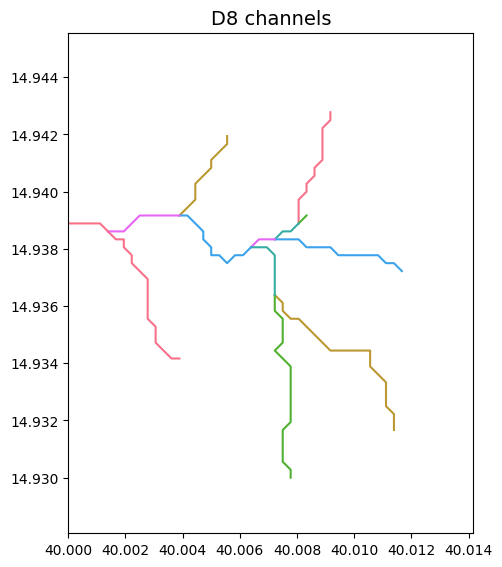

In [ ]:
# This sets the seaborn color palette to "HUSL", which is useful for creating visually appealing and distinct colors plots
sns.set_palette('husl')

# Create figures and axes
fig, ax = plt.subplots(figsize=(8.5,6.5))

# Set the limits
   # Set the x and y limits based on the bounding box of the grid,  to ensure the plot only shows the area of interest.
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])

# Aspect ratio
   # This ensures that the scale of the axes is equal, so one unit in x is equal to one unit in y, preventing distortion.
ax.set_aspect('equal')

# Plot the river channels
   # Iterates through each extracted river channel and plots it on the figure. The river channels are drawn as lines.
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

# add title of the plot
  #The underscore before the assignment is a convention in Python indicating that the value is not intended to be used elsewhere.
_ = plt.title('D8 channels', size=14)

## Calcuate Distance to Outlet

### This line computes the distance from each cell in the grid to the specified outlet point (x_snap, y_snap).
### Parameters:
  ### x: x-coordinate of the outlet.
  ### y: y-coordinate of the outlet.
  ### fdir: flow direction raster, indicating the direction of water flow from each cell.
  ### dirmap: specifies the mapping of flow directions.
  ### xytype: specifies the type of coordinates being used (in this case, 'coordinate').

In [ ]:
# Calculate distance to outlet from each cell

dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

### Visualizing Distance to Outlets

Text(0.5, 1.0, 'Flow Distance')

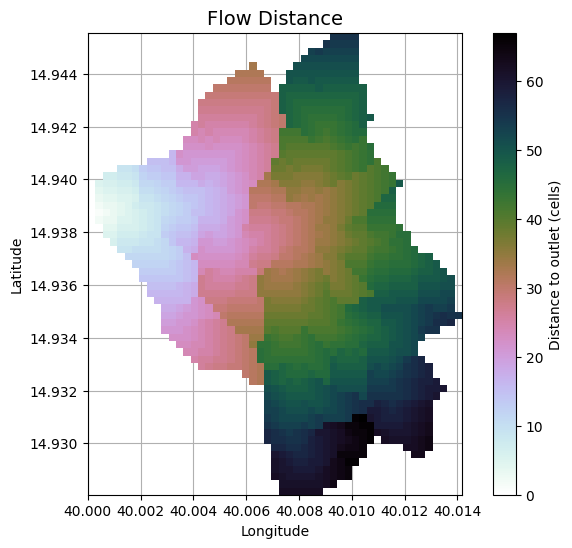

In [ ]:
# Create a figure and axis with specified size
fig, ax = plt.subplots(figsize=(8,6))

# Set the figure background color to transparent
fig.patch.set_alpha(0)

# Enable the grid for better readability
plt.grid('on', zorder=0)

# Display the distance to the outlet
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')

# Add a colorbar with a label
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')

# Set axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set the plot title
plt.title('Flow Distance', size=14)